In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer, normalize
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn , KNeighborsRegressor as knr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering 
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from functions import *
from math import radians, pi
from sklearn.cluster import AgglomerativeClustering 
import json
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
rfm = pd.read_csv("DATA/rfm.csv", index_col=0)
raw_data = pd.read_csv("DATA/raw_data.csv", index_col=0)

In [3]:
raw_data['order_purchase_timestamp'] = pd.to_datetime(raw_data['order_purchase_timestamp'])

## [CLUSTERING METHODE RFM](#sommaire)<a class="anchor" id="9"></a>

For n_clusters = 2 The average silhouette_score is : 0.42871196698742287
For n_clusters = 3 The average silhouette_score is : 0.45910394389005243
For n_clusters = 4 The average silhouette_score is : 0.4635329186933711
For n_clusters = 5 The average silhouette_score is : 0.47587500985183045
For n_clusters = 6 The average silhouette_score is : 0.408521401387542


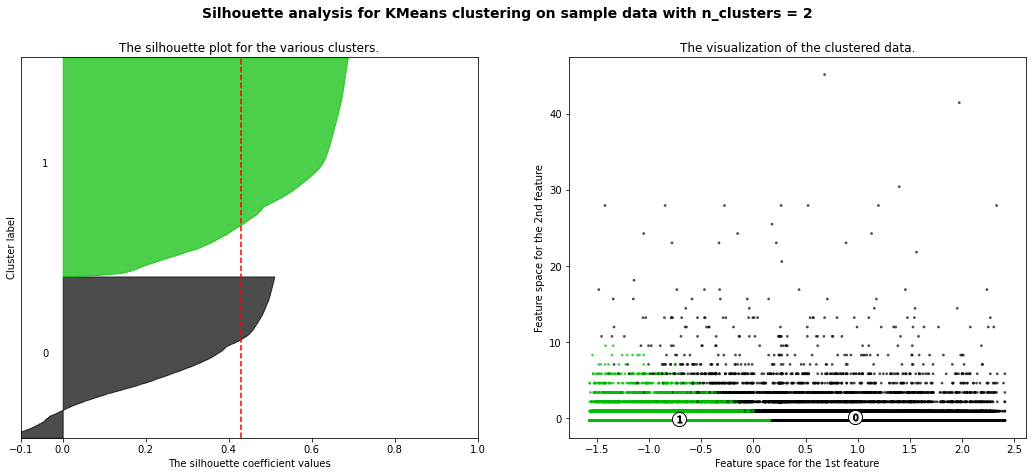

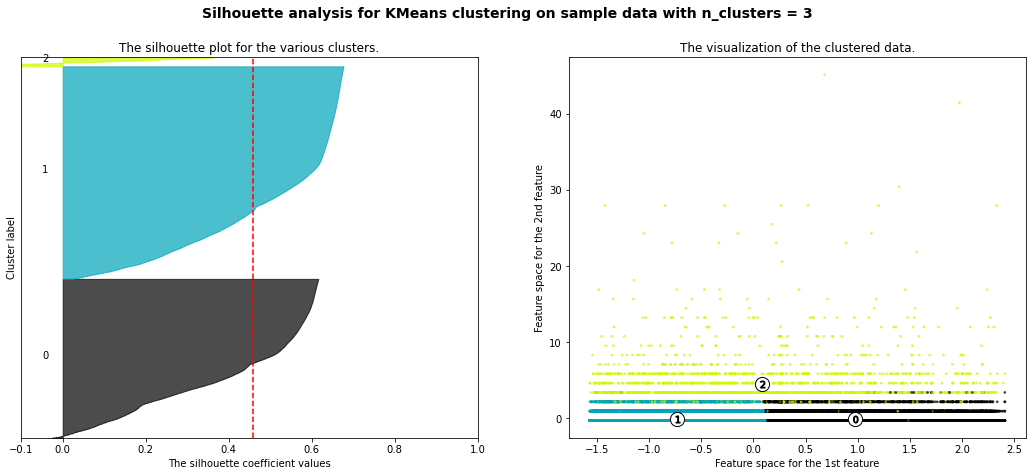

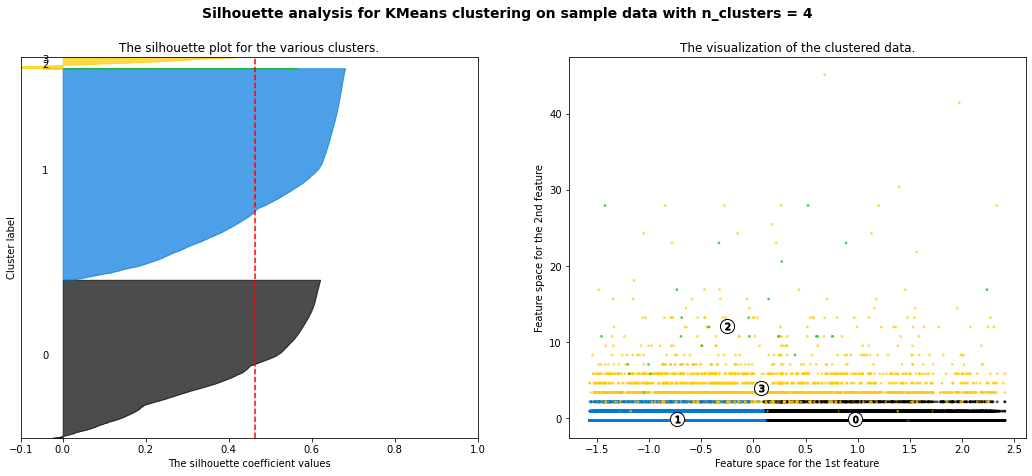

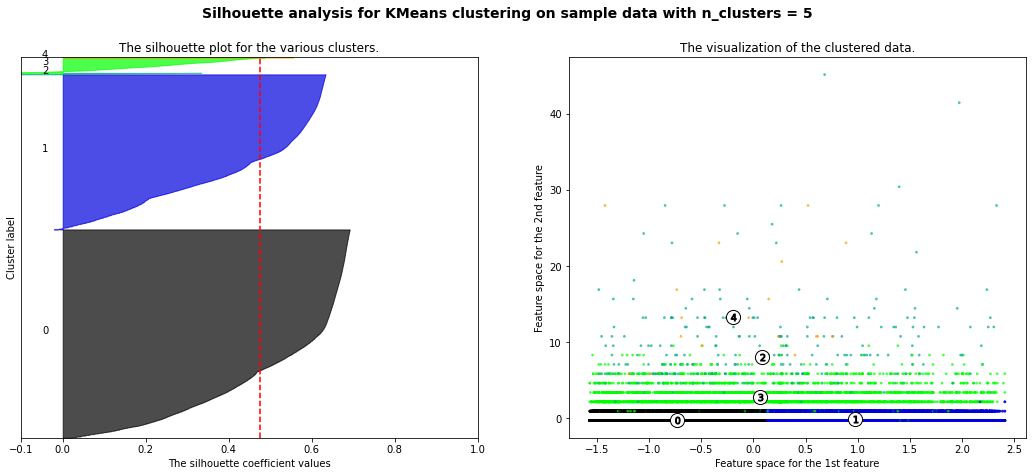

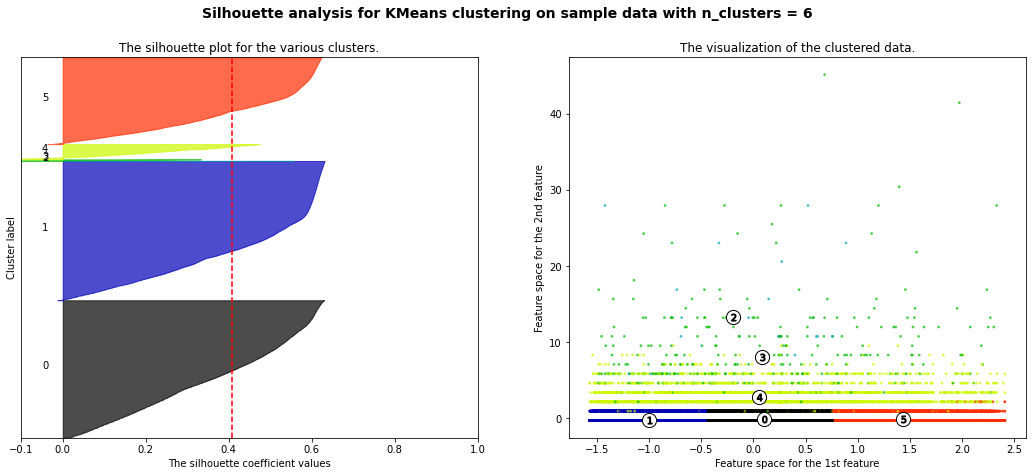

In [4]:
X = rfm.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

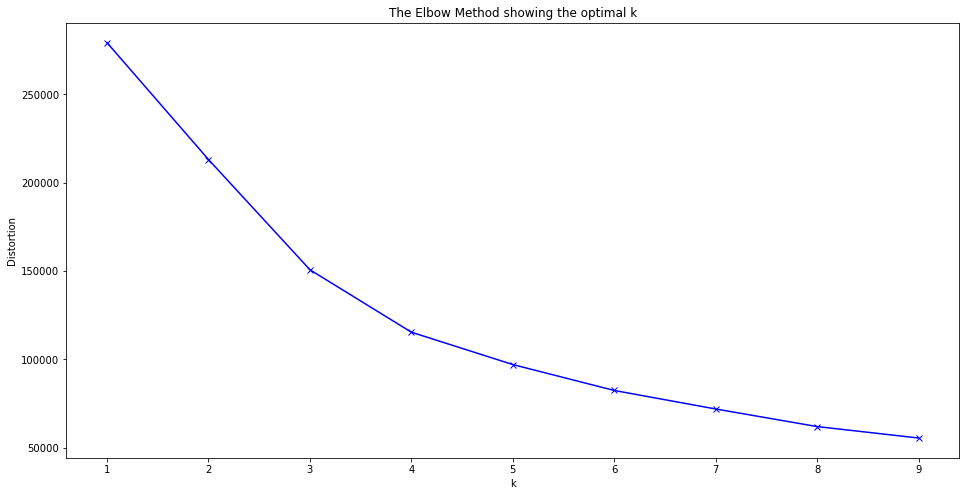

In [5]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

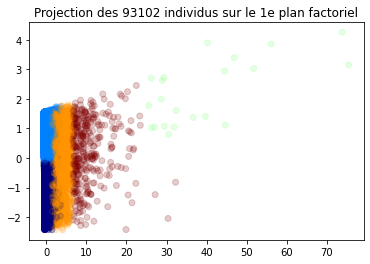

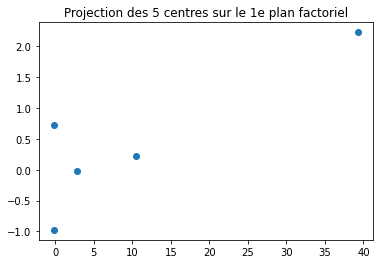

In [6]:
# Nombre de clusters souhaités
n_clust = 5

# préparation des données pour le clustering
# X = donnees.drop("is_genuine", axis = 1).values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)


# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

# Affichage des positions des centres de classes
plt.figure()
centroids5 = km.cluster_centers_
centroids_projected = pca.transform(centroids5)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids5)))
plt.show()

<AxesSubplot:>

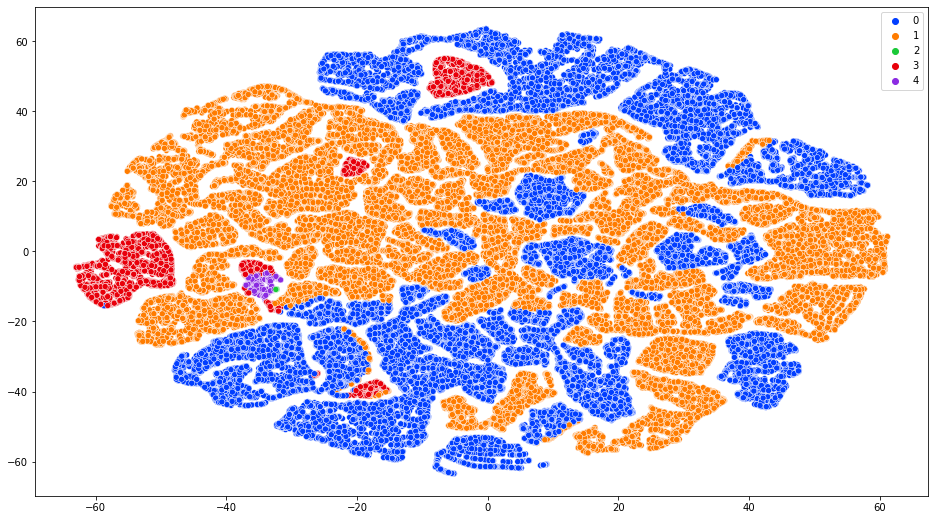

In [7]:
y = km.labels_
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

In [8]:
rfm['kmeans'] = km.labels_

In [9]:
centroid = rfm.groupby('kmeans').mean()
centroid

Recent  Frequency         Mount
kmeans                                     
0       384.265377   1.117825    166.521670
1       126.689160   1.107083    165.861498
2       207.714286  12.095238  23009.541905
3       246.391547   3.535885    810.720521
4       248.642077   7.803279   3819.156202

<AxesSubplot:xlabel='Recent', ylabel='Mount'>

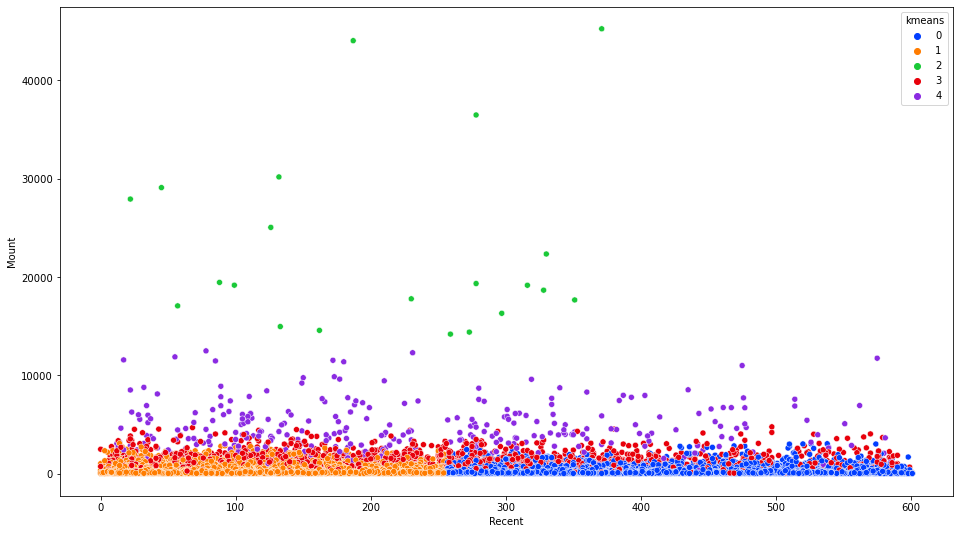

In [10]:
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(data = rfm, x='Recent', y='Mount', hue='kmeans', legend='full', palette='bright')

<AxesSubplot:xlabel='Recent', ylabel='Frequency'>

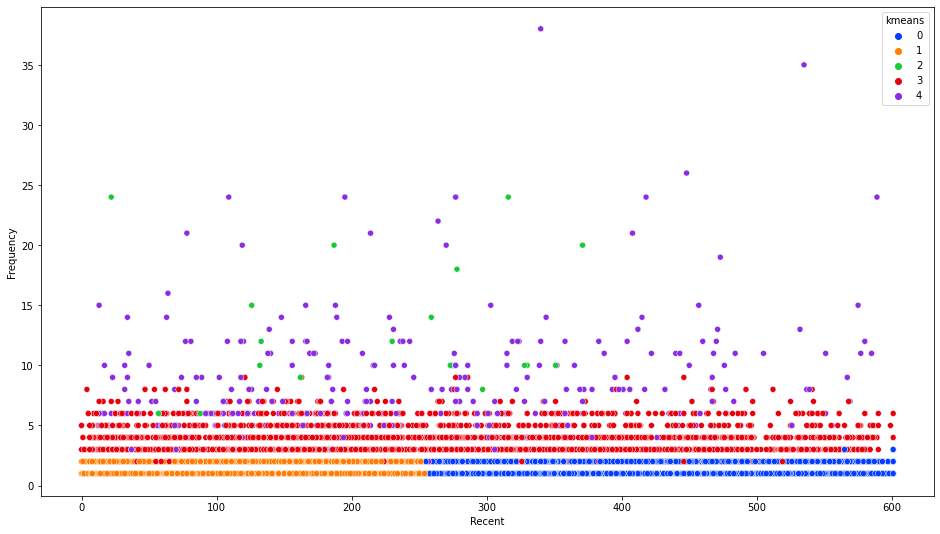

In [11]:
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(data = rfm, x='Recent', y='Frequency', hue='kmeans', legend='full', palette='bright')

In [12]:
centroid['Frequency'] = centroid['Frequency'].apply(lambda x: (x-rfm['Frequency'].min())/(rfm['Frequency'].max()-rfm['Frequency'].min()))
centroid['Recent'] = centroid['Recent'].apply(lambda x: (rfm['Recent'].max()-x)/(rfm['Recent'].max()-rfm['Recent'].min()))
centroid['Mount'] = centroid['Mount'].apply(lambda x: (x-rfm['Mount'].min())/(rfm['Mount'].max()-rfm['Mount'].min()))

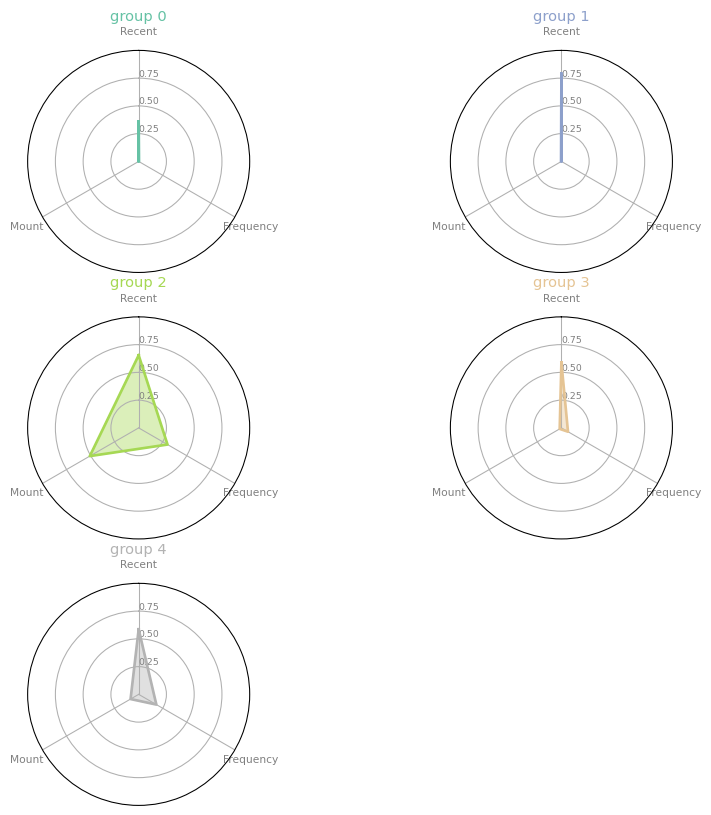

In [13]:

# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(df, row, nb_plot, title, color):

    # number of variable
    categories=list(df.columns)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(np.ceil(nb_plot/2),2,row+1, polar=True, )
    
    

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25,0.50,0.75], ["0.25","0.50","0.75"], color="grey", size=7)
    plt.ylim(0,1)

    labels = [["abcd"],["abcd"], ["abcd"]]
    
    # Ind1
    values=df.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(centroid.index))
 
# Loop to plot
nb_plot = len(centroid.index)

for row in range(0, nb_plot):
    make_spider(df=centroid, row=row, nb_plot=nb_plot, title='group '+str(centroid.index[row]), color=my_palette(row))

## [SEGMENTATION CLIENTS AUGMENTEE](#sommaire)<a class="anchor" id="10"></a>

In [14]:
def formatage_donnees(raw_data):
    temp = raw_data.groupby(['customer_unique_id', 'Gross_category']).agg({'review_score':'mean', 'order_purchase_timestamp':'last','payment_value':'sum'})
    temp = temp.reset_index()
    temp = temp.pivot(index = ['customer_unique_id', 'order_purchase_timestamp', 'review_score'], columns = 'Gross_category', values = 'payment_value')
    temp = temp.reset_index()
    temp.columns.name = ''
    temp = temp.reindex()
    a = temp.groupby('customer_unique_id').agg({'review_score':'mean', 'order_purchase_timestamp':'last'})
    b = temp.drop(['review_score', 'order_purchase_timestamp'],axis = 1).groupby('customer_unique_id').sum()
    temp = pd.merge(a, b, left_index = True, right_index = True)
    temp = temp.rename(columns={'order_purchase_timestamp':'Recent'})
    temp['Recent'] = raw_data['order_purchase_timestamp'].max() - temp['Recent']
    temp['Recent'] = temp['Recent'].apply(lambda x: x.days)
    temp = temp.fillna(0)
    
    return temp

In [15]:
temp = formatage_donnees(raw_data)

### KMEANS

In [16]:
X = temp.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

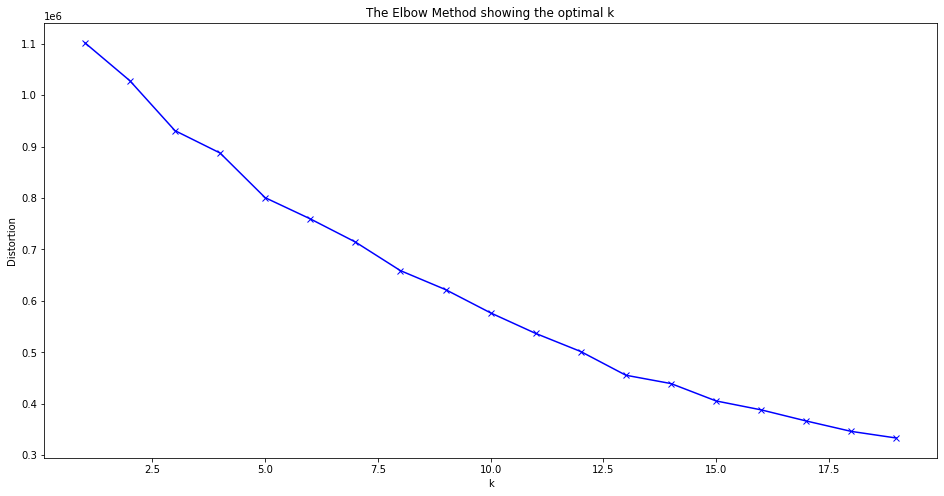

In [17]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.9901089983876127
For n_clusters = 4 The average silhouette_score is : 0.3187181058552974
For n_clusters = 6 The average silhouette_score is : 0.24783460574377986
For n_clusters = 8 The average silhouette_score is : 0.256426122483069


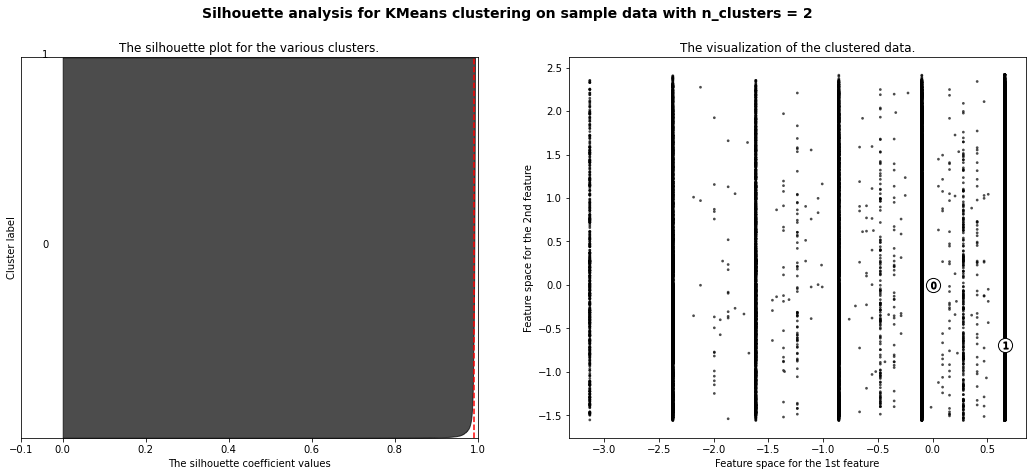

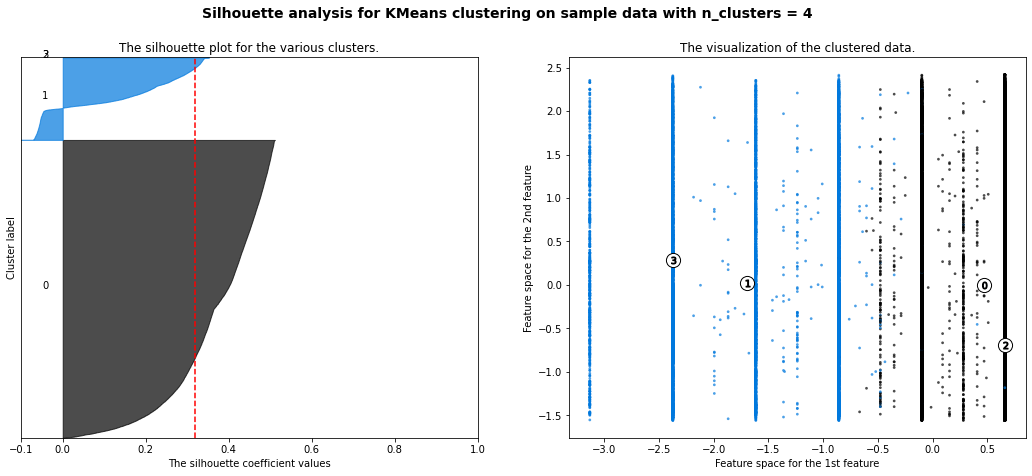

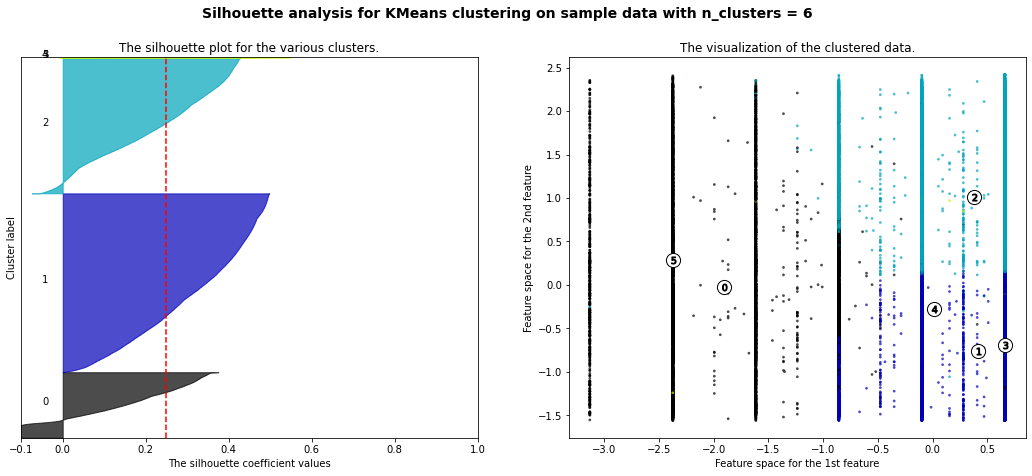

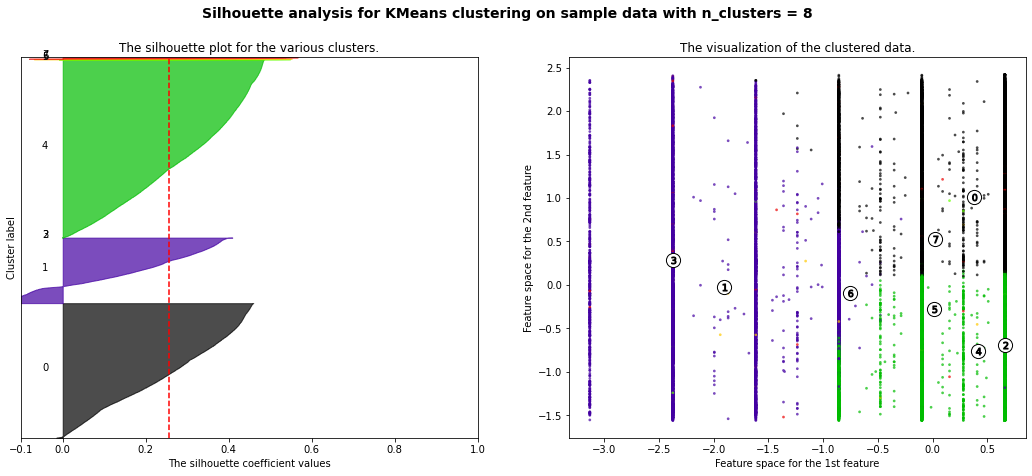

In [18]:

range_n_clusters = [2, 4, 6, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

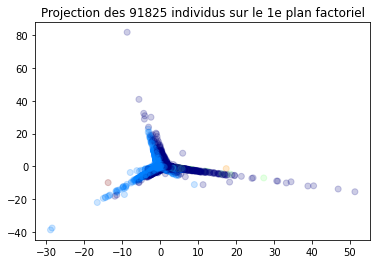

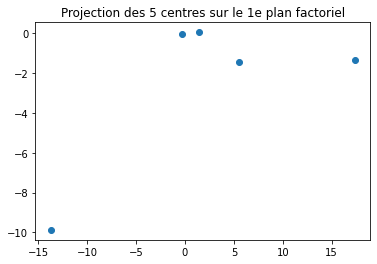

In [19]:
# Nombre de clusters souhaités
n_clust = 5

# préparation des données pour le clustering
# X = donnees.drop("is_genuine", axis = 1).values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)


# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

# Affichage des positions des centres de classes
plt.figure()
centroids5 = km.cluster_centers_
centroids_projected = pca.transform(centroids5)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids5)))
plt.show()

<AxesSubplot:>

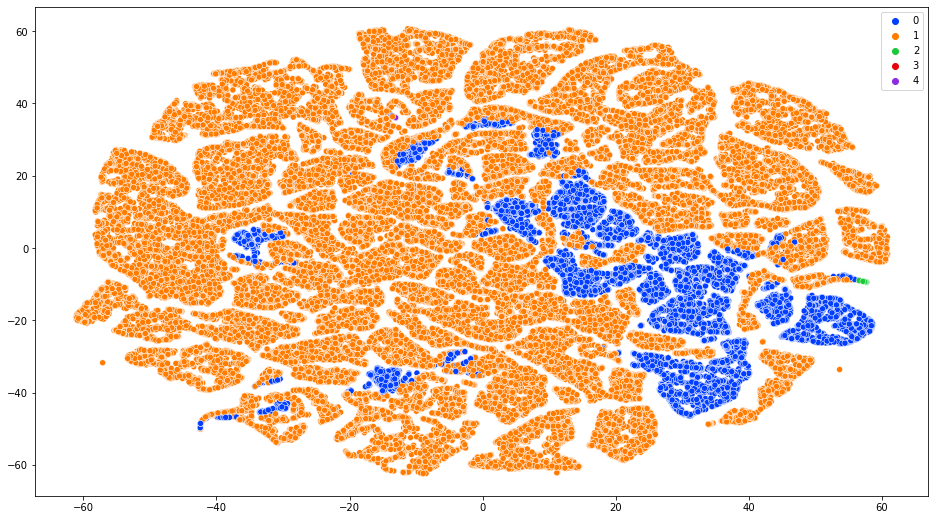

In [20]:
y = km.labels_
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette='bright')

In [21]:
temp['kmeans'] = km.labels_
centroid = temp.groupby('kmeans').mean()

In [22]:
centroid.describe()

review_score      Recent  Alimentation   Animaux      Autre  Bricolage  \
count      5.000000    5.000000      5.000000  5.000000   5.000000   5.000000   
mean       3.055269  222.940831   6037.683235  1.247486   3.795057  21.077254   
std        1.816945   54.170130  13499.319471  1.723754   5.247194  21.803828   
min        1.000000  132.000000      0.000000  0.000000   0.000000   0.000000   
25%        1.399075  232.882353      0.000000  0.000000   0.000000   0.000000   
50%        3.269532  235.369600      1.202030  0.000000   0.000000  18.451685   
75%        4.607738  236.452202      1.214144  2.791878   8.459605  42.124706   
max        5.000000  278.000000  30186.000000  3.445555  10.515681  44.809879   

       Cosmétique&habillement  Domotique&electronique      Industry  \
count                5.000000                5.000000      5.000000   
mean                10.803252             1768.682728   7298.508935   
std                 14.837318             3913.874724  16318.114766   
min                  0.000000                0.000000      0.000000   
25%                  0.000000                0.000000      0.000000   
50%                  0.000000               30.759519      1.376373   
75%                 25.386841               42.700592      1.928302   
max                 28.629418             8769.953529  36489.240000   

          Loisir     Meubles    Nursery  
count   5.000000    5.000000   5.000000  
mean   22.376862   37.512104   3.512976  
std    30.708689   63.808460   5.696104  
min     0.000000    0.000000   0.000000  
25%     0.000000    0.000000   0.000000  
50%     2.342745    0.000000   0.000000  
75%    43.140038   40.243384   4.468224  
max    66.401526  147.317134  13.096654

In [23]:
centroid

review_score      Recent  Alimentation   Animaux      Autre  \
kmeans                                                                
0           1.399075  236.452202      1.202030  2.791878  10.515681   
1           4.607738  235.369600      1.214144  3.445555   8.459605   
2           3.269532  232.882353      0.000000  0.000000   0.000000   
3           1.000000  278.000000      0.000000  0.000000   0.000000   
4           5.000000  132.000000  30186.000000  0.000000   0.000000   

        Bricolage  Cosmétique&habillement  Domotique&electronique  \
kmeans                                                              
0       44.809879               25.386841               42.700592   
1       18.451685               28.629418               30.759519   
2       42.124706                0.000000             8769.953529   
3        0.000000                0.000000                0.000000   
4        0.000000                0.000000                0.000000   

            Industry     Loisir     Meubles    Nursery  
kmeans                                                  
0           1.928302  66.401526  147.317134  13.096654  
1           1.376373  43.140038   40.243384   4.468224  
2           0.000000   2.342745    0.000000   0.000000  
3       36489.240000   0.000000    0.000000   0.000000  
4           0.000000   0.000000    0.000000   0.000000

In [24]:
plot_centroid = centroid.copy()

In [25]:
for i in plot_centroid.columns:
    if i == 'Recent':
        plot_centroid[i] = plot_centroid[i].apply(lambda x: (plot_centroid[i].max()-x)/(plot_centroid[i].max()-plot_centroid[i].min()))
    else: 
        plot_centroid[i] = plot_centroid[i].apply(lambda x: (x-plot_centroid[i].min())/(plot_centroid[i].max()-plot_centroid[i].min()))

In [26]:
plot_centroid

review_score    Recent  Alimentation   Animaux     Autre  Bricolage  \
kmeans                                                                        
0           0.099769  0.284574       0.00004  0.810284  1.000000   1.000000   
1           0.901934  0.291989       0.00004  1.000000  0.804475   0.411777   
2           0.567383  0.309025       0.00000  0.000000  0.000000   0.940076   
3           0.000000  0.000000       0.00000  0.000000  0.000000   0.000000   
4           1.000000  1.000000       1.00000  0.000000  0.000000   0.000000   

        Cosmétique&habillement  Domotique&electronique  Industry    Loisir  \
kmeans                                                                       
0                      0.88674                0.004869  0.000053  1.000000   
1                      1.00000                0.003507  0.000038  0.649684   
2                      0.00000                1.000000  0.000000  0.035281   
3                      0.00000                0.000000  1.000000  0.000000   
4                      0.00000                0.000000  0.000000  0.000000   

         Meubles   Nursery  
kmeans                      
0       1.000000  1.000000  
1       0.273175  0.341173  
2       0.000000  0.000000  
3       0.000000  0.000000  
4       0.000000  0.000000

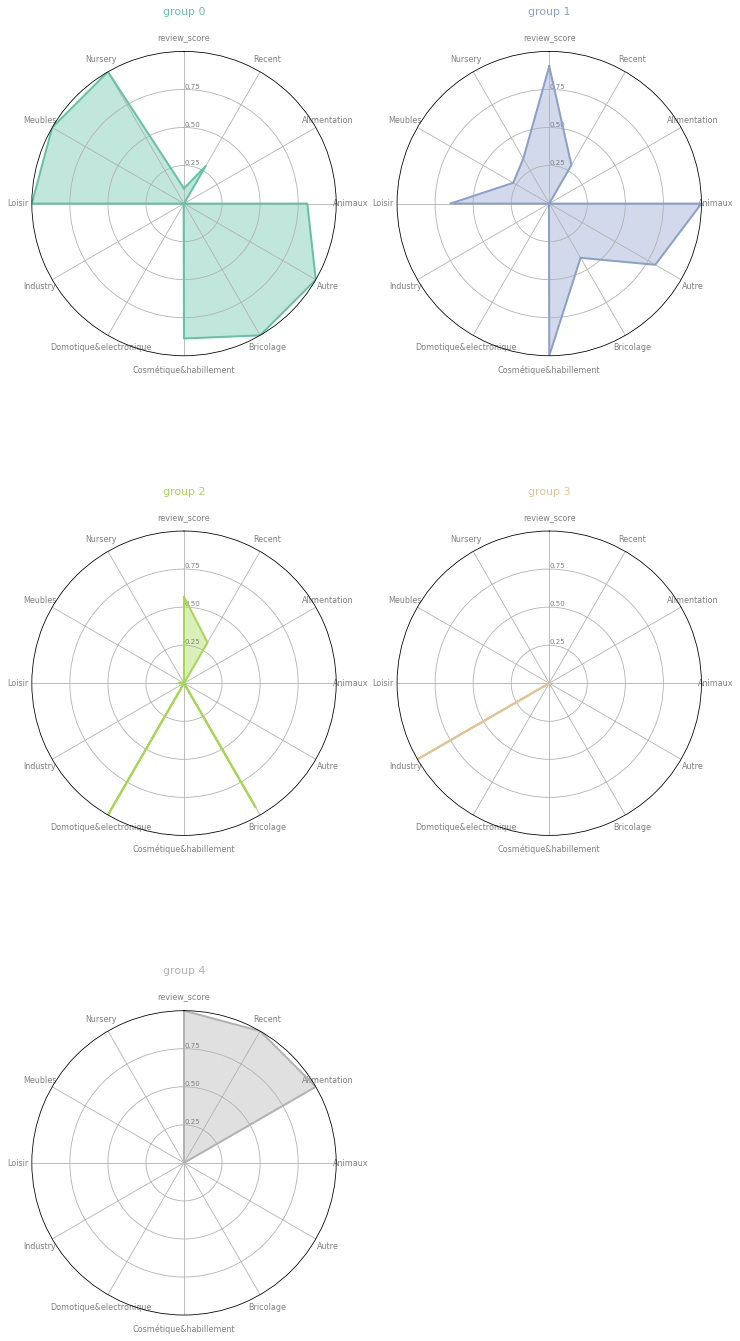

In [27]:

# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(df, row, nb_plot, title, color):

    # number of variable
    categories=list(df.columns)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(np.ceil(nb_plot/2),2,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25,0.50,0.75], ["0.25","0.50","0.75"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(12,25))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(plot_centroid.index))
 
# Loop to plot
nb_plot = len(plot_centroid.index)

for row in range(0, nb_plot):
    make_spider(df=plot_centroid, row=row, nb_plot=nb_plot, title='group '+str(plot_centroid.index[row]), color=my_palette(row))

## DBSCAN

Estimated number of clusters: 12
Estimated number of noise points: 1705
Silhouette Coefficient: 0.360


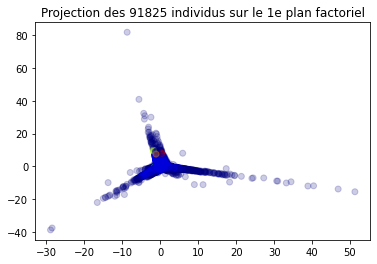

In [28]:
db = DBSCAN(eps=0.8, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=labels.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

<AxesSubplot:>

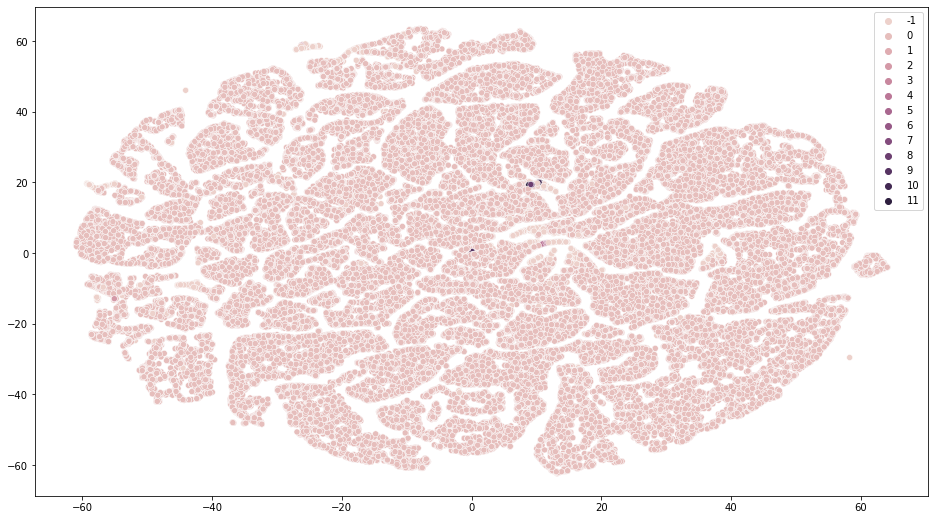

In [29]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize=(16,9)) 
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full')

In [30]:
temp['ch'] = labels
centroid = temp.drop('kmeans', axis=1).groupby('ch').mean()

In [31]:
centroid

review_score      Recent  Alimentation     Animaux       Autre  \
ch                                                                    
-1       3.163379  245.724927     42.898528   74.768985  104.075273   
 0       4.148856  235.353937      0.759187    1.852363    6.892250   
 1       1.000000  417.916667      0.000000    0.000000    0.000000   
 2       1.000000  166.411765      0.000000    0.000000  410.498824   
 3       1.333333  173.555556      0.000000    0.000000    0.000000   
 4       4.846154   77.076923      0.000000  469.474615    0.000000   
 5       1.000000  138.888889      0.000000    0.000000    0.000000   
 6       4.788462  167.538462      0.000000    0.000000    0.000000   
 7       3.300000  197.400000      0.000000    0.000000    0.000000   
 8       4.916667  487.750000      0.000000    0.000000    0.000000   
 9       1.000000  488.111111      0.000000  101.531111    0.000000   
 10      1.100000  204.500000      0.000000    0.000000    0.000000   
 11      4.000000  288.750000      0.000000    0.000000    0.000000   

       Bricolage  Cosmétique&habillement  Domotique&electronique   Industry  \
ch                                                                            
-1    271.561660              164.792141              472.756510  61.519718   
 0     17.258980               25.586961               29.205399   0.727683   
 1   2023.607500                0.000000                0.000000   0.000000   
 2      0.000000                0.000000                0.000000   0.000000   
 3      0.000000                0.000000                0.000000   0.000000   
 4      0.000000                0.000000                0.000000   0.000000   
 5   1818.592222                0.000000                0.000000   0.000000   
 6      0.000000                0.000000                1.466538   0.000000   
 7      0.000000                0.000000                0.000000   0.000000   
 8      0.000000                0.000000                0.000000   0.000000   
 9      0.000000                0.000000                0.000000   0.000000   
 10     0.000000                0.000000                0.000000   0.000000   
 11     0.000000                0.000000                0.000000   0.000000   

          Loisir     Meubles      Nursery  
ch                                         
-1    250.455853  555.748428   106.664669  
 0     41.652605   46.814708     3.620276  
 1      0.000000    0.000000     0.000000  
 2      0.000000    0.000000     0.000000  
 3      0.000000    0.000000  1030.595556  
 4      0.000000    0.000000     0.000000  
 5      0.000000    0.000000     0.000000  
 6   2061.173846    0.000000     0.000000  
 7      0.000000    0.000000   416.800000  
 8   1667.074167    0.000000     0.000000  
 9      0.000000    0.000000     0.000000  
 10  1723.698000    0.000000     0.000000  
 11  1553.178750    0.000000     0.000000

In [32]:
plot_centroid = centroid.copy()

for i in plot_centroid.columns:
    if i == 'Recent':
        plot_centroid[i] = plot_centroid[i].apply(lambda x: (plot_centroid[i].max()-x)/(plot_centroid[i].max()-plot_centroid[i].min()))
    else: 
        plot_centroid[i] = plot_centroid[i].apply(lambda x: (x-plot_centroid[i].min())/(plot_centroid[i].max()-plot_centroid[i].min()))

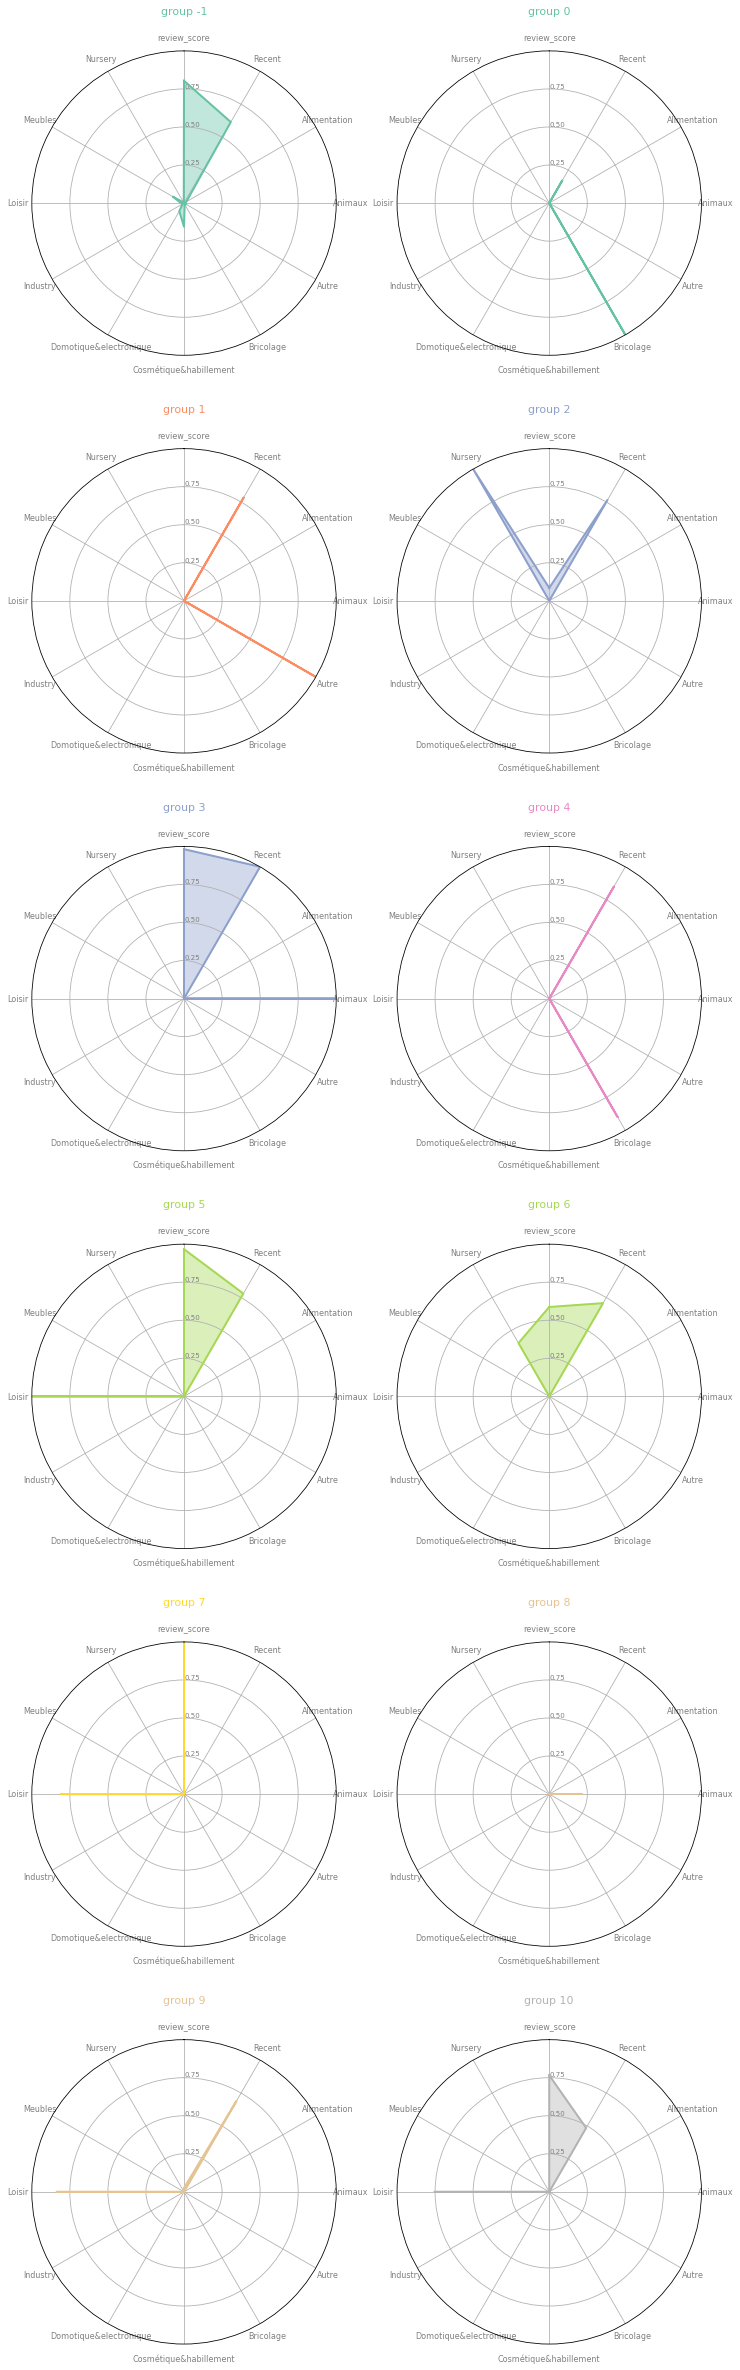

In [33]:
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(12,50))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(plot_centroid.index))
 
# Loop to plot
nb_plot = len(plot_centroid.index)

for row in range(0, nb_plot-1):
    make_spider(df=plot_centroid, row=row, nb_plot=nb_plot, title='group '+str(plot_centroid.index[row]), color=my_palette(row))

In [34]:
df_unique = formatage_donnees(raw_data)
df_unique.shape

(91825, 12)

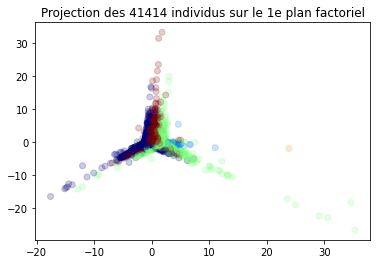

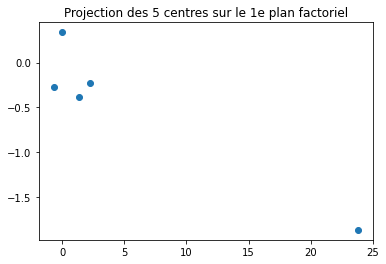

In [35]:
df_reference = raw_data[raw_data['year'] == 2017]
temp = formatage_donnees(df_reference)

X = temp.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)


# préparation des données pour le clustering
# X = donnees.drop("is_genuine", axis = 1).values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)


# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

# Affichage des positions des centres de classes
plt.figure()
centroids5 = km.cluster_centers_
centroids_projected = pca.transform(centroids5)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids5)))
plt.show()

In [36]:
temp['kmeans_init'] = km.labels_
df_unique = pd.merge(df_unique, temp['kmeans_init'], left_index = True, right_index = True, how='left')

In [37]:
df_unique.index.nunique()

91825

In [38]:
df_unique

review_score  Recent  Alimentation  Animaux  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2           5.0     111           0.0      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f           4.0     114           0.0      0.0   
0000f46a3911fa3c0805444483337064           3.0     536           0.0      0.0   
0000f6ccb0745a6a4b88665a16c9f078           4.0     320           0.0      0.0   
0004aac84e0df4da2b147fca70cf8255           5.0     287           0.0      0.0   
...                                        ...     ...           ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684           5.0     446           0.0      0.0   
fffea47cd6d3cc0a88bd621562a9d061           4.0     261           0.0      0.0   
ffff371b4d645b6ecea244b27531430a           5.0     567           0.0      0.0   
ffff5962728ec6157033ef9805bacc48           5.0     118           0.0      0.0   
ffffd2657e2aad2907e67c3e9daecbeb           5.0     483           0.0      0.0   

                                  Autre  Bricolage  Cosmétique&habillement  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2    0.0       0.00                    0.00   
0000b849f77a49e4a4ce2b2a4ca5be3f    0.0       0.00                   27.19   
0000f46a3911fa3c0805444483337064    0.0       0.00                    0.00   
0000f6ccb0745a6a4b88665a16c9f078    0.0       0.00                    0.00   
0004aac84e0df4da2b147fca70cf8255    0.0       0.00                    0.00   
...                                 ...        ...                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    0.0       0.00                 4134.84   
fffea47cd6d3cc0a88bd621562a9d061    0.0       0.00                    0.00   
ffff371b4d645b6ecea244b27531430a    0.0     112.46                    0.00   
ffff5962728ec6157033ef9805bacc48    0.0       0.00                    0.00   
ffffd2657e2aad2907e67c3e9daecbeb    0.0       0.00                   71.56   

                                  Domotique&electronique  Industry  Loisir  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2                    0.00       0.0    0.00   
0000b849f77a49e4a4ce2b2a4ca5be3f                    0.00       0.0    0.00   
0000f46a3911fa3c0805444483337064                    0.00       0.0   86.22   
0000f6ccb0745a6a4b88665a16c9f078                   43.62       0.0    0.00   
0004aac84e0df4da2b147fca70cf8255                  196.89       0.0    0.00   
...                                                  ...       ...     ...   
fffcf5a5ff07b0908bd4e2dbc735a684                    0.00       0.0    0.00   
fffea47cd6d3cc0a88bd621562a9d061                    0.00       0.0    0.00   
ffff371b4d645b6ecea244b27531430a                    0.00       0.0    0.00   
ffff5962728ec6157033ef9805bacc48                    0.00       0.0  133.69   
ffffd2657e2aad2907e67c3e9daecbeb                    0.00       0.0    0.00   

                                  Meubles  Nursery  kmeans_init  
customer_unique_id                                               
0000366f3b9a7992bf8c76cfdf3221e2    141.9     0.00          NaN  
0000b849f77a49e4a4ce2b2a4ca5be3f      0.0     0.00          NaN  
0000f46a3911fa3c0805444483337064      0.0     0.00          0.0  
0000f6ccb0745a6a4b88665a16c9f078      0.0     0.00          4.0  
0004aac84e0df4da2b147fca70cf8255      0.0     0.00          4.0  
...                                   ...      ...          ...  
fffcf5a5ff07b0908bd4e2dbc735a684      0.0     0.00          0.0  
fffea47cd6d3cc0a88bd621562a9d061      0.0    84.58          4.0  
ffff371b4d645b6ecea244b27531430a      0.0     0.00          0.0  
ffff5962728ec6157033ef9805bacc48      0.0     0.00          NaN  
ffffd2657e2aad2907e67c3e9daecbeb      0.0     0.00          0.0  

[91825 rows x 13 columns]

## [TEST STABILITE MODELE DANS LE TEMPS](#sommaire)<a class="anchor" id="11"></a>

In [39]:
df_move = raw_data.copy()

In [40]:
decalage = 1

for i in df_move.year.unique():
    mask = df_move['year'] == i
    l_month = df_move.loc[mask, "month"].unique()
    for j in l_month :
        mask = (df_move['year'] == i) & (df_move['month'] >= j) | (df_move['year'] == (i+1)) & (df_move['month'] <= j)
        temp = df_move.loc[mask, :]
        temp = formatage_donnees(temp)
        
        # Standardisation
        X = temp.to_numpy()
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # Clustering par K-means
        km = KMeans(n_clusters=n_clust)
        km.fit(X)
        
        nom_col = "decalage_" + str(decalage)

        temp[nom_col] = km.labels_
        df_unique = pd.merge(df_unique, temp[nom_col], left_index = True, right_index = True, how='left')

        decalage +=1

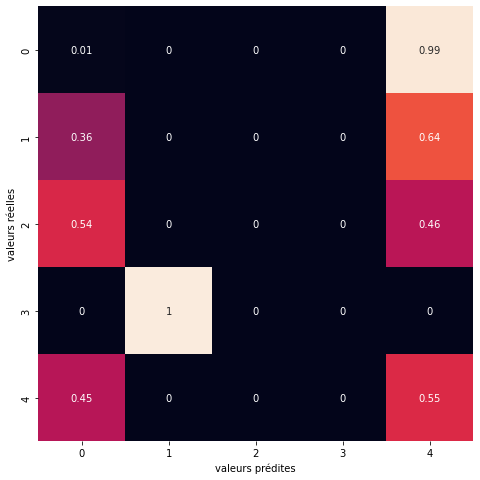

In [41]:
ene = df_unique.loc[:, ['kmeans_init', 'decalage_6']].dropna()
conf = np.round(confusion_matrix(ene['kmeans_init'], ene['decalage_6'], normalize='true'), 2)
plt.subplots(figsize=(16,8))
sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(np.arange(0,5))
            , yticklabels=list(np.arange(0,5)), fmt='g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles');

In [42]:
precision_score = []
score_list = []
for i in range(1, 9):
    name = 'decalage_' + str(i)
    ene = df_unique.loc[:, ['kmeans_init', name]].dropna()
    conf = confusion_matrix(ene['kmeans_init'], ene[name], normalize='true')
    #plt.subplots(figsize=(16,8))
    #sns.heatmap(conf, square=True, annot=True, cbar=False
    #            , xticklabels=list(np.arange(0,14))
    #            , yticklabels=list(np.arange(0,14)), fmt='g')
    #plt.xlabel('valeurs prédites')
    #plt.ylabel('valeurs réelles');
    for i in range(0, conf.shape[0]-1, 1):
        precision_score.append(conf[i,:].max())
    score_list.append(np.round(np.mean(precision_score),2))

In [43]:
precision_score = []
score_list = []
for i in range(1, decalage):
    name = 'decalage_' + str(i)
    ene = df_unique.loc[:, ['kmeans_init', name]].dropna()
    score_list.append(adjusted_rand_score(ene["kmeans_init"], ene[name]))
    #plt.subplots(figsize=(16,8))
    #sns.heatmap(conf, square=True, annot=True, cbar=False
    #            , xticklabels=list(np.arange(0,14))
    #            , yticklabels=list(np.arange(0,14)), fmt='g')
    #plt.xlabel('valeurs prédites')
    #plt.ylabel('valeurs réelles');

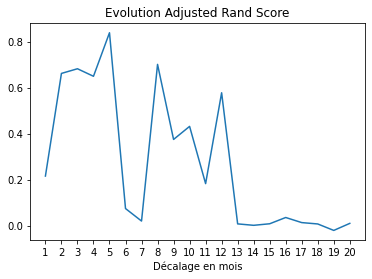

In [44]:
plt.plot(range(1,decalage), score_list)
plt.title("Evolution Adjusted Rand Score")
plt.xlabel('Décalage en mois')
plt.xticks(range(1,decalage))
plt.show()

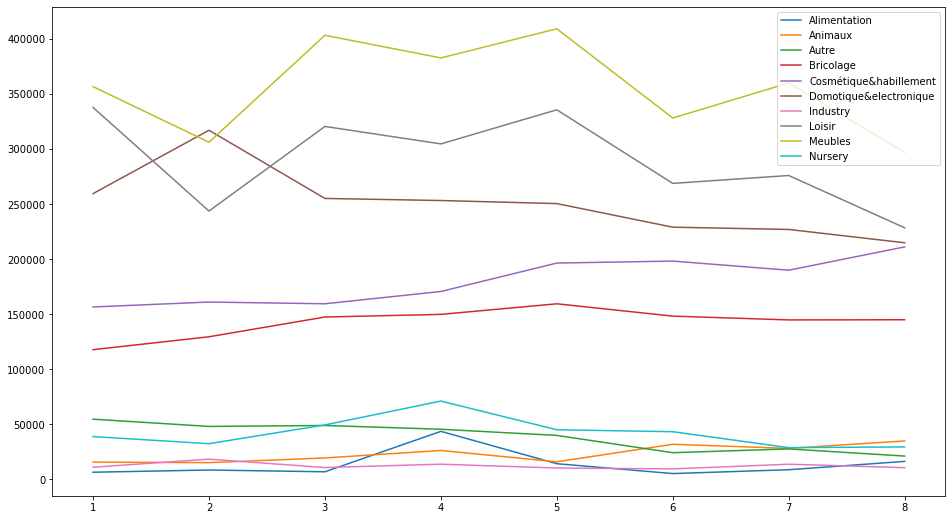

In [45]:
temp = raw_data[raw_data['year']==2018]
temp = temp.groupby(['Gross_category', 'month']).agg({'payment_value':'sum'})
temp = temp.pivot_table(index = 'Gross_category', columns = 'month', values = 'payment_value')
plt.figure(figsize= (16,9))
plt.plot(temp.transpose(), label = temp.transpose().columns)
plt.legend()
plt.show()